In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2 
from pathlib import Path
import os
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Activation, ReLU, Flatten, Dense, Add,\
    Dropout,MaxPooling2D,Concatenate,Reshape
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
import warnings
from pathlib import Path
# Tüm uyarıları kapat
warnings.filterwarnings("ignore")
import seaborn as sns

2024-08-21 13:59:23.200788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 13:59:23.200836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 13:59:23.202281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 224
target_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)

def rescale_to_shape(array, target_shape):
    factors = [t / s for s, t in zip(array.shape, target_shape)]
    return scipy.ndimage.zoom(array, zoom=factors, mode='nearest')

In [3]:
path = "/home/grup17/data_npy"
DATA_PATH = Path(path)
labels = ['AD',"CN","EMCI","MCI"]

In [4]:
data=[]
for disease_id , sp in enumerate(labels):
    for file in os.listdir(os.path.join(DATA_PATH, sp)):
        data.append(['{}/{}'.format(sp, file), disease_id, sp])
csv_data = pd.DataFrame(data, columns=['File', 'Disease Id', 'Disease Type'])
csv_data

,File,Disease Id,Disease Type
0,AD/ADNI_130_S_1290_MR_MPR__GradWarp__B1_Correc...,0,AD
1,AD/ADNI_128_S_1430_MR_MPR-R__GradWarp__B1_Corr...,0,AD
2,AD/ADNI_082_S_5184_MR_MT1__GradWarp__N3m_Br_20...,0,AD
3,AD/ADNI_010_S_5163_MR_MT1__N3m_Br_201306190939...,0,AD
4,AD/ADNI_128_S_5123_MR_MT1__GradWarp__N3m_Br_20...,0,AD
...,...,...,...
983,MCI/ADNI_062_S_1294_MR_MPR__GradWarp__B1_Corre...,3,MCI
984,MCI/ADNI_128_S_1406_MR_MT1__GradWarp__N3m_Br_2...,3,MCI
985,MCI/ADNI_016_S_1138_MR_MPR__GradWarp__B1_Corre...,3,MCI
986,MCI/ADNI_012_S_0917_MR_MPR____N3_Br_2007092313...,3,MCI


In [5]:
import pandas as pd
import re

# CSV dosyasını okuyun
df = csv_data

def extract_subject_id(filename):
    # Adjust regex to match the specific pattern
    match = re.search(r'ADNI_(\d+_S_\d+)', filename)
    if match:
        return match.group(1)
    return None
# `file` sütunundan `subject_id`'yi çıkarıp yeni bir sütun oluşturun
df['subject_id'] = df['File'].apply(extract_subject_id)
# Yeni DataFrame'i yazdırın veya kaydedin
df

,File,Disease Id,Disease Type,subject_id
0,AD/ADNI_130_S_1290_MR_MPR__GradWarp__B1_Correc...,0,AD,130_S_1290
1,AD/ADNI_128_S_1430_MR_MPR-R__GradWarp__B1_Corr...,0,AD,128_S_1430
2,AD/ADNI_082_S_5184_MR_MT1__GradWarp__N3m_Br_20...,0,AD,082_S_5184
3,AD/ADNI_010_S_5163_MR_MT1__N3m_Br_201306190939...,0,AD,010_S_5163
4,AD/ADNI_128_S_5123_MR_MT1__GradWarp__N3m_Br_20...,0,AD,128_S_5123
...,...,...,...,...
983,MCI/ADNI_062_S_1294_MR_MPR__GradWarp__B1_Corre...,3,MCI,062_S_1294
984,MCI/ADNI_128_S_1406_MR_MT1__GradWarp__N3m_Br_2...,3,MCI,128_S_1406
985,MCI/ADNI_016_S_1138_MR_MPR__GradWarp__B1_Corre...,3,MCI,016_S_1138
986,MCI/ADNI_012_S_0917_MR_MPR____N3_Br_2007092313...,3,MCI,012_S_0917


In [6]:
from sklearn.model_selection import train_test_split
# Get unique subject IDs
unique_subject_ids = df['subject_id'].unique()

train_val_subjects, test_subjects = train_test_split(
    unique_subject_ids,
    test_size=0.2,  
    random_state=42  
)

train_subjects, val_subjects = train_test_split(
    train_val_subjects,
    test_size=0.2,
    random_state=42 
)
# Create train and test sets
train_df = df[df['subject_id'].isin(train_subjects)]
val_df = df[df['subject_id'].isin(val_subjects)]
test_df = df[df['subject_id'].isin(test_subjects)]

print("Train DataFrame:")
print(len(train_df))
print("\nVal DataFrame:")
print(len(val_df))
print("\nTest DataFrame:")
print(len(test_df))

Train DataFrame:
637

Val DataFrame:
164

Test DataFrame:
187


In [7]:
X_train_item = np.zeros((train_df.shape[0], IMAGE_SIZE, IMAGE_SIZE,IMAGE_SIZE))
for i, file in tqdm(enumerate(train_df['File'].values)):
    loaded_data = np.load(path+"/"+file)
    if (loaded_data is not None):
        data_array = loaded_data[loaded_data.files[0]]
        X_train_item[i] = rescale_to_shape(data_array, target_shape)

637it [08:40,  1.22it/s]


In [8]:
X_train = (X_train_item - np.min(X_train_item)) / (np.max(X_train_item) - np.min(X_train_item))#normalize data
print('Train Shape: {}'.format(X_train.shape))

Y_train = train_df['Disease Id'].values
Y_train = to_categorical(Y_train)

Train Shape: (637, 32, 32, 32)


In [9]:
X_val_item = np.zeros((val_df.shape[0], IMAGE_SIZE, IMAGE_SIZE,IMAGE_SIZE))
for i, file in tqdm(enumerate(val_df['File'].values)):
    loaded_data = np.load(path+"/"+file)
    if (loaded_data is not None):
        data_array = loaded_data[loaded_data.files[0]]
        X_val_item[i] = rescale_to_shape(data_array, target_shape)

164it [02:05,  1.31it/s]


In [10]:
X_val = (X_val_item - np.min(X_val_item)) / (np.max(X_val_item) - np.min(X_val_item))#normalize data
print('Validation Shape: {}'.format(X_val.shape))

Y_val = val_df['Disease Id'].values
Y_val = to_categorical(Y_val)

Validation Shape: (164, 32, 32, 32)


In [11]:
X_test_item = np.zeros((test_df.shape[0], IMAGE_SIZE, IMAGE_SIZE,IMAGE_SIZE))
for i, file in tqdm(enumerate(test_df['File'].values)):
    loaded_data = np.load(path+"/"+file)
    if (loaded_data is not None):
        data_array = loaded_data[loaded_data.files[0]]
        X_test_item[i] = rescale_to_shape(data_array, target_shape)

187it [02:32,  1.23it/s]


In [12]:
X_test = (X_test_item - np.min(X_test_item)) / (np.max(X_test_item) - np.min(X_test_item))#normalize data
print('Test Shape: {}'.format(X_test.shape))

Y_test = test_df['Disease Id'].values
Y_test = to_categorical(Y_test)

Test Shape: (187, 32, 32, 32)


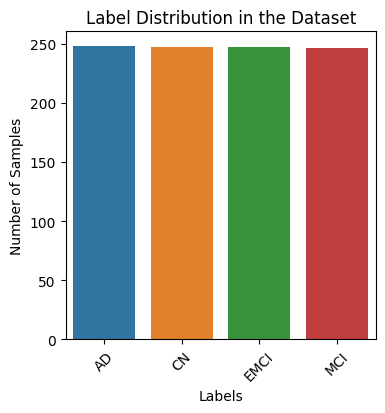

In [13]:
class_counts = csv_data['Disease Type'].value_counts()
plt.figure(figsize=(4, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout,Lambda
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Giriş katmanı, gri görüntü olarak (224x224x1)
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1))

# Gri görüntüleri 3 kanala dönüştürüyoruz (ResNet50'nin RGB bekleyen ilk katmanına uyacak şekilde)
def gray_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

# Lambda katmanı ile gri görüntüyü RGB'ye dönüştürüyoruz
rgb_images = TimeDistributed(Lambda(gray_to_rgb))(input_layer)

# ResNet50 modelini alıyoruz (önceden eğitilmiş, üst katmanlar olmadan)
cnn_base = ResNet50(weights='imagenet', include_top=False)

# ResNet50'yi TimeDistributed katmanına sarıyoruz
cnn_output = TimeDistributed(cnn_base)(rgb_images)

# Çıkışı düzleştiriyoruz
cnn_output_flat = TimeDistributed(Flatten())(cnn_output)

# LSTM katmanı ekliyoruz
lstm_output = LSTM(256, return_sequences=False)(cnn_output_flat)

# Son katman (sınıflandırma için)
output_layer = Dense(4, activation='softmax')(lstm_output)

# Modeli tanımlıyoruz
model = Model(inputs=input_layer, outputs=output_layer)

from keras.metrics import F1Score
# Modeli Derleme
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',F1Score()])


In [ ]:
batch_size = 16
epochs = 150
hist_concat = model.fit(
    [X_train],Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_val],Y_val)
    )

Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 979s 1s/step - accuracy: 0.2973 - loss: 1.4433 - val_accuracy: 0.2561 - val_loss: 1.4438
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.3571 - loss: 1.3254 - val_accuracy: 0.2561 - val_loss: 1.3902
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.3618 - loss: 1.3278 - val_accuracy: 0.2561 - val_loss: 1.4256
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.3952 - loss: 1.2976 - val_accuracy: 0.2561 - val_loss: 1.4225
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.3666 - loss: 1.3341 - val_accuracy: 0.2561 - val_loss: 1.3925
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.3857 - loss: 1.3147 - val_accuracy: 0.2561 - val_loss: 1.3999
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.3579 - loss: 1.3191 - val_accuracy: 0.2561 - val_loss: 1.4282
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.3628 - loss: 1.3019 - val_accu

In [ ]:
y_pred = model.predict([X_test])
y_pred = np.argmax(y_pred, axis=1).reshape(-1, 1)
Y_test = np.argmax(Y_test, axis=1).reshape(-1, 1)

In [ ]:
def model_result(Y_test,y_pred):
    print(" MODEL RESULTS")
    print("Accuracy: ", accuracy_score(Y_test, y_pred))
    print("F1_Score: ", f1_score(Y_test, y_pred, average='macro'))
    print("Precision: ", precision_score(Y_test, y_pred, average='macro'))
    print("Sensitivity: ", recall_score(Y_test, y_pred, average='macro'))

In [ ]:
import matplotlib.pyplot as plt
def Plot_acc_history(hist_concat):
    plt.plot(hist_concat.history['accuracy'])
    plt.plot(hist_concat.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
def Plot_loss_history(hist_concat):
    plt.plot(hist_concat.history['loss'])
    plt.plot(hist_concat.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def Confusion_matrix(Y_test,y_pred):
    class_names = labels
    print('Test Confusion Matrix')
    cm_dense = confusion_matrix(Y_test, y_pred)
    sn.set(font_scale=1.2)  # for label size
    sn.heatmap(cm_dense, annot=True, fmt="d", linewidths=.5, annot_kws={"size": 16},xticklabels=class_names, yticklabels=class_names)

In [ ]:
model_result(Y_test,y_pred)

In [ ]:
Plot_acc_history(hist_concat)
Plot_loss_history(hist_concat)

In [ ]:
Confusion_matrix(Y_test,y_pred)